<a href="https://colab.research.google.com/github/SJR-kang/datamining-programming/blob/main/Classification_Model_for_Identifying_At_Risk_College_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Classification Model for Identifying At-Risk College Students**
Using Random Forest and Logistic Regression

> Add blockquote



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Balanced_Dataset_Expanded.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of students: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Dataset shape: (302, 26)
Number of students: 302
Number of features: 26


###**EDA**

In [3]:
df.head()

,Timestamp,Year Level (last semester),College (last semester),Sex,What was your General Weighted Average (GWA) for the most recent semester?,How many subjects have you failed in the most recent semester?,"Approximately, what was your attendance rate in classes last semester?",How many academic units were you enrolled in during the most recent (last) semester?,Part Time Job,"If you answered ""Yes"" to the question above, how many hours did you work per week?",...,"If you answered ""Yes"" to the question above, how many hours per week did you spend on extracurricular activities in the last semester?",Stress level,Financial Difficulty,Level of Social Support,Preferred Learning Style,At-Risk/Not At-Risk,GWA_num,Failed_num,Attendance_num,At_Risk_Recomputed
0,10/19/2025 17:30,4,College of Education,Prefer not to say,1.76 - 2.25,Prefer not to say,75% - 89%,18,No,0,...,0,4,5,3,"Kinesthetic, Visual",At-Risk,2.25,0,75.0,1
1,11/2/2025 10:46,2,College of Education,Male,2.26 - 2.75,NaN,Prefer not to say,18,Yes,15,...,5,2,3,2,"Kinesthetic, Visual, Auditory, Reading/Writing",At-Risk,2.75,0,NaN,1
2,11/6/2025 9:55,2,College of Agriculture,Male,Prefer not to say,1 subject,90% and above,18,No,0,...,2,3,2,3,"Kinesthetic, Reading/Writing",At-Risk,NaN,1,90.0,1
3,10/17/2025 13:03,4,College of Information Sciences and Computing,Female,1.0 - 1.75,3 or more subjects,75% - 89%,15,Yes,20,...,0,1,3,5,"Kinesthetic, Auditory, Reading/Writing",At-Risk,1.75,3,75.0,1
4,11/13/2025 10:25,3,College of Engineering,Female,Prefer not to say,2 subjects,Prefer not to say,18,Yes,10,...,0,4,2,3,"Kinesthetic, Reading/Writing",At-Risk,NaN,2,NaN,1


In [4]:
#check missing values
print("\nMissing values:")
df.isnull().sum()


Missing values:


,0
Timestamp,0
Year Level (last semester),0
College (last semester),0
Sex,0
What was your General Weighted Average (GWA) for the most recent semester?,0
How many subjects have you failed in the most recent semester?,107
"Approximately, what was your attendance rate in classes last semester?",0
How many academic units were you enrolled in during the most recent (last) semester?,0
Part Time Job,0
"If you answered ""Yes"" to the question above, how many hours did you work per week?",0


In [5]:
# Find the most common response (excluding 'Prefer not to say')
non_missing = df[df['How many subjects have you failed in the most recent semester?   '] != 'Prefer not to say']
most_common = non_missing['How many subjects have you failed in the most recent semester?   '].mode()[0]

# Fill missing values with the most common response
df['How many subjects have you failed in the most recent semester?   '] = df['How many subjects have you failed in the most recent semester?   '].replace('Prefer not to say', most_common)

print(f"Filled {len(df[df['How many subjects have you failed in the most recent semester?   '] == 'Prefer not to say'])} missing values with: {most_common}")

Filled 0 missing values with: 1 subject


In [6]:
#target variable distribution
target_col = 'At-Risk/Not At-Risk'
print(f"\nTarget Variable Distribution ({target_col}):")
print(df[target_col].value_counts())
print(f"\nTarget Variable Percentage:")
print(df[target_col].value_counts(normalize=True) * 100)


Target Variable Distribution (At-Risk/Not At-Risk):
At-Risk/Not At-Risk
Not At-Risk    159
At-Risk        143
Name: count, dtype: int64

Target Variable Percentage:
At-Risk/Not At-Risk
Not At-Risk    52.649007
At-Risk        47.350993
Name: proportion, dtype: float64


In [7]:
# Make a copy of the dataframe
df_clean = df.copy()

#drop columns
columns_to_drop = [
    'Timestamp',
    'Year Level',
    'College (last semester)',
    'Sex',
    'How many subjects have you failed in the most recent semester?   ',
    'What was your General Weighted Average (GWA) for the most recent semester?  ',
    'Approximately, what was your attendance rate in classes last semester?   '
]

# Drop columns that exist in the dataframe
existing_columns_to_drop = [col for col in columns_to_drop if col in df_clean.columns]
df_clean = df_clean.drop(columns=existing_columns_to_drop)

print(f"\nDropped {len(existing_columns_to_drop)} columns:")
for col in existing_columns_to_drop:
    print(f"  - {col}")

print(f"\nRemaining columns: {df_clean.shape[1]}")
print(f"Remaining features (excluding target): {df_clean.shape[1] - 1}")


Dropped 6 columns:
  - Timestamp
  - College (last semester)
  - Sex
  - How many subjects have you failed in the most recent semester?   
  - What was your General Weighted Average (GWA) for the most recent semester?  
  - Approximately, what was your attendance rate in classes last semester?   

Remaining columns: 20
Remaining features (excluding target): 19


###**DATA PREPROCESSING AND CLEANING**

In [8]:
categorical_cols = ['Part Time Job', 'How often did you submit school requirements(e.g. Assignments, Projects) late?', 'Were you involved in extracurricular activities (e.g., student orgs, sports, volunteering)?  ', 'Preferred Learning Style']
df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns], drop_first=True)
print("One-hot encoding done. Updated columns:", df.columns)

One-hot encoding done. Updated columns: Index(['Timestamp', 'Year Level (last semester)', 'College (last semester)',
       'Sex',
       'What was your General Weighted Average (GWA) for the most recent semester?  ',
       'How many subjects have you failed in the most recent semester?   ',
       'Approximately, what was your attendance rate in classes last semester?   ',
       'How many academic units were you enrolled in during the most recent (last) semester?   ',
       'If you answered "Yes" to the question above, how many hours did you work per week?',
       'On average, how many hours did you study on weekdays?  ',
       'On average, how many hours did you study on weekends?  ',
       'On average, how many hours did you sleep per night? ',
       'On average, how many hours did you spend gaming per day? ',
       'If you answered "Yes" to the question above, how many hours per week did you spend on extracurricular activities in the last semester?  ',
       'Stress level'

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Map long column names to shorter, more convenient names
rename_map = {
    'On average, how many hours did you spend gaming per day? ': 'Hours Gaming',
    'How often did you submit school requirements(e.g. Assignments, Projects) late?': 'Late Submissions',
    'On average, how many hours did you study on weekdays?  ': 'Study Hours (Weekdays)',
    'On average, how many hours did you study on weekends?  ': 'Study Hours (Weekends)',
    'If you answered "Yes" to the question above, how many hours did you work per week?': 'Work Hours',
    'If you answered "Yes" to the question above, how many hours per week did you spend on extracurricular activities in the last semester?  ': 'Hours Extracurricular Activity',
    'How many academic units were you enrolled in during the most recent (last) semester?   ': 'Academic unit',
    'Were you involved in extracurricular activities (e.g., student orgs, sports, volunteering)?  ': 'Extracurricular Activities',
    'Stress level': 'Stress Level',
    'Level of Social Support': 'Social Support',
    'On average, how many hours did you sleep per night? ': 'Sleep Hours'
}

# Apply renaming to df_clean
existing_columns_to_rename = {old_name: new_name for old_name, new_name in rename_map.items() if old_name in df_clean.columns}
df_clean.rename(columns=existing_columns_to_rename, inplace=True)

# Improved data cleaning function
def clean_numeric_column(column_name, default_value=0):
    if column_name in df_clean.columns:
        # Replace problematic values
        df_clean[column_name] = df_clean[column_name].replace(['Prefer not to say', 'NaN', 'None', '?', '#VALUE!', ''], np.nan)

        # Convert to numeric, forcing conversion
        df_clean[column_name] = pd.to_numeric(df_clean[column_name], errors='coerce')

        # Fill NaN values
        if df_clean[column_name].isna().any():
            fill_value = df_clean[column_name].median() if not df_clean[column_name].isna().all() else default_value
            df_clean[column_name].fillna(fill_value, inplace=True)
            print(f"Filled {df_clean[column_name].isna().sum()} NaN values with {fill_value}")
        return True
    return False

# Clean Hours Gaming first with special handling
df_clean['Hours Gaming'] = df_clean['Hours Gaming'].astype(str)
df_clean['Hours Gaming'] = df_clean['Hours Gaming'].replace(['Prefer not to say', 'NaN', 'None', '?', '#VALUE!', ''], '0')
df_clean['Hours Gaming'] = pd.to_numeric(df_clean['Hours Gaming'], errors='coerce')
df_clean['Hours Gaming'].fillna(0, inplace=True)

# Clean other numeric columns
clean_numeric_column('Work Hours', 0)
clean_numeric_column('Hours Extracurricular Activity', 0)
clean_numeric_column('Study Hours (Weekdays)', 0)
clean_numeric_column('Study Hours (Weekends)', 0)
clean_numeric_column('Academic unit', 0)
clean_numeric_column('Sleep Hours', 7)
clean_numeric_column('Stress Level', 3)
clean_numeric_column('Social Support', 3)
clean_numeric_column('Financial Difficulty', 3)

# Encode Late Submissions if it's categorical
if df_clean['Late Submissions'].dtype == 'object':
    late_mapping = {'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4}
    df_clean['Late Submissions'] = df_clean['Late Submissions'].map(late_mapping)
    df_clean['Late Submissions'].fillna(2.5, inplace=True)
else:
        # If already numeric, ensure no zeros
    df_clean['Late Submissions'] = df_clean['Late Submissions'].replace(0, 1)

# Create engineered features with robust error handling
print("\nCreating engineered features...")

engineered_features = {}

# Total Study Hours
if all(col in df_clean.columns for col in ['Study Hours (Weekdays)', 'Study Hours (Weekends)']):
    df_clean["Total Study Hours"] = df_clean["Study Hours (Weekdays)"] + df_clean["Study Hours (Weekends)"]
    engineered_features["Total Study Hours"] = df_clean["Total Study Hours"]
    print("Created: Total Study Hours")

# Study Efficiency
if all(col in df_clean.columns for col in ['Total Study Hours', 'Late Submissions']):
    df_clean["StudyEfficiency"] = df_clean["Total Study Hours"] / (df_clean["Late Submissions"] + 0.1)
    engineered_features["StudyEfficiency"] = df_clean["StudyEfficiency"]
    print("Created: StudyEfficiency")

# Academic Engagement
if all(col in df_clean.columns for col in ['Hours Extracurricular Activity', 'Social Support']):
    df_clean["AcademicEngagement"] = df_clean["Hours Extracurricular Activity"] + df_clean["Social Support"]
    engineered_features["AcademicEngagement"] = df_clean["AcademicEngagement"]
    print("Created: AcademicEngagement")

# Stress Balance
if all(col in df_clean.columns for col in ['Stress Level', 'Social Support']):
    df_clean["StressBalance"] = df_clean["Stress Level"] - df_clean["Social Support"]
    engineered_features["StressBalance"] = df_clean["StressBalance"]
    print("Created: StressBalance")

# Time Burden
if all(col in df_clean.columns for col in ['Work Hours', 'Hours Gaming']):
    df_clean["TimeBurden"] = df_clean["Work Hours"] + df_clean["Hours Gaming"]
    engineered_features["TimeBurden"] = df_clean["TimeBurden"]
    print("Created: TimeBurden")

# Study Gaming Ratio
if all(col in df_clean.columns for col in ['Total Study Hours', 'Hours Gaming']):
    gaming_hours = df_clean["Hours Gaming"].replace(0, 0.1)
    df_clean["StudyGamingRatio"] = df_clean["Total Study Hours"] / gaming_hours
    engineered_features["StudyGamingRatio"] = df_clean["StudyGamingRatio"]
    print("Created: StudyGamingRatio")

# Additional engineered features
if all(col in df_clean.columns for col in ['Sleep Hours', 'Total Study Hours']):
    df_clean["SleepStudyRatio"] = df_clean["Sleep Hours"] / (df_clean["Total Study Hours"] + 1)
    engineered_features["SleepStudyRatio"] = df_clean["SleepStudyRatio"]
    print("Created: SleepStudyRatio")

if all(col in df_clean.columns for col in ['Total Study Hours', 'Academic unit']):
    df_clean["StudyPerUnit"] = df_clean["Total Study Hours"] / (df_clean["Academic unit"] + 0.1)
    engineered_features["StudyPerUnit"] = df_clean["StudyPerUnit"]
    print("Created: StudyPerUnit")


Creating engineered features...
Created: Total Study Hours
Created: StudyEfficiency
Created: AcademicEngagement
Created: StressBalance
Created: TimeBurden
Created: StudyGamingRatio
Created: SleepStudyRatio
Created: StudyPerUnit


In [10]:
# Create engineered-only dataframe
engineered_feature_names = list(engineered_features.keys())
print(f"\nEngineered features created: {engineered_feature_names}")

if engineered_feature_names and 'At-Risk/Not At-Risk' in df_clean.columns:
    df_engineered = df_clean[engineered_feature_names + ['At-Risk/Not At-Risk']].copy()

    # Check for infinite values and replace them
    for col in engineered_feature_names:
        df_engineered[col] = df_engineered[col].replace([np.inf, -np.inf], np.nan)
        if df_engineered[col].isna().any():
            df_engineered[col].fillna(df_engineered[col].median(), inplace=True)

    print(f"\nEngineered dataset shape: {df_engineered.shape}")
    print(f"Target variable distribution:")
    print(df_engineered['At-Risk/Not At-Risk'].value_counts())

    # Data validation
    print("\nData validation - Missing values in engineered features:")
    print(df_engineered[engineered_feature_names].isnull().sum())

    # Prepare for correlation analysis
    df_for_corr = df_engineered.copy()

    # Encode target variable
    target_mapping = {'At-Risk': 1, 'Not At-Risk': 0}
    df_for_corr['Target_Encoded'] = df_for_corr['At-Risk/Not At-Risk'].map(target_mapping)

    # Create correlation matrix
    numeric_columns = [col for col in df_for_corr.columns if col != 'At-Risk/Not At-Risk']
    correlation_matrix = df_for_corr[numeric_columns].corr()

    print(f"\nCorrelation matrix shape: {correlation_matrix.shape}")



Engineered features created: ['Total Study Hours', 'StudyEfficiency', 'AcademicEngagement', 'StressBalance', 'TimeBurden', 'StudyGamingRatio', 'SleepStudyRatio', 'StudyPerUnit']

Engineered dataset shape: (302, 9)
Target variable distribution:
At-Risk/Not At-Risk
Not At-Risk    159
At-Risk        143
Name: count, dtype: int64

Data validation - Missing values in engineered features:
Total Study Hours     0
StudyEfficiency       0
AcademicEngagement    0
StressBalance         0
TimeBurden            0
StudyGamingRatio      0
SleepStudyRatio       0
StudyPerUnit          0
dtype: int64

Correlation matrix shape: (9, 9)


###**DATA VISUALIZATION**


Correlation with Target (At-Risk/Not At-Risk):
Target_Encoded        1.000000
StudyGamingRatio      0.388198
StudyPerUnit          0.135310
Total Study Hours     0.047303
SleepStudyRatio       0.022360
StressBalance        -0.036958
AcademicEngagement   -0.127706
TimeBurden           -0.145394
StudyEfficiency      -0.165318
Name: Target_Encoded, dtype: float64


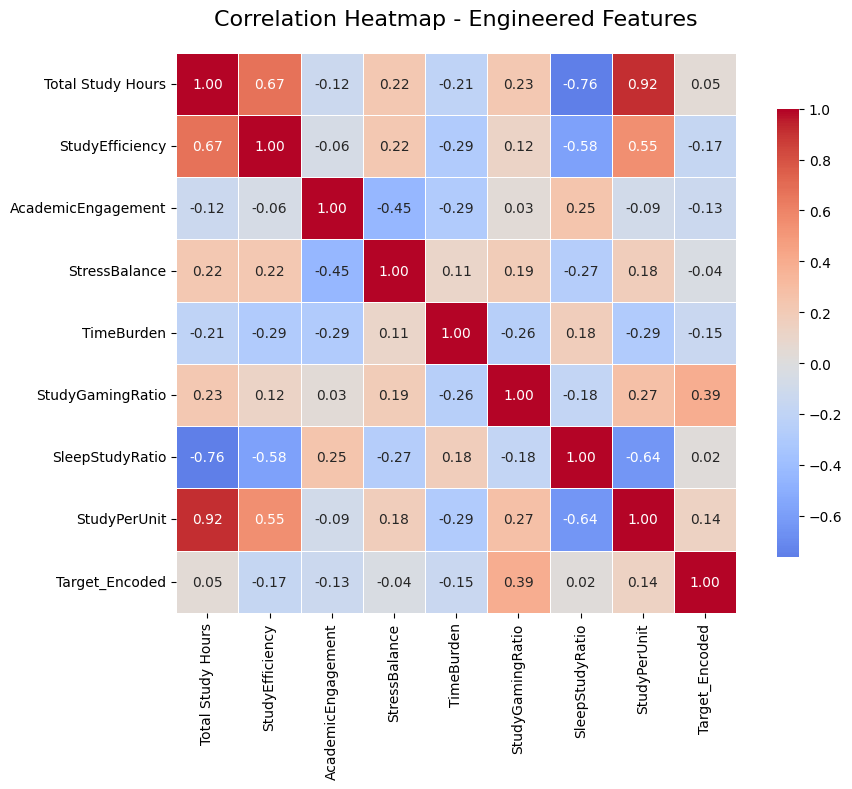

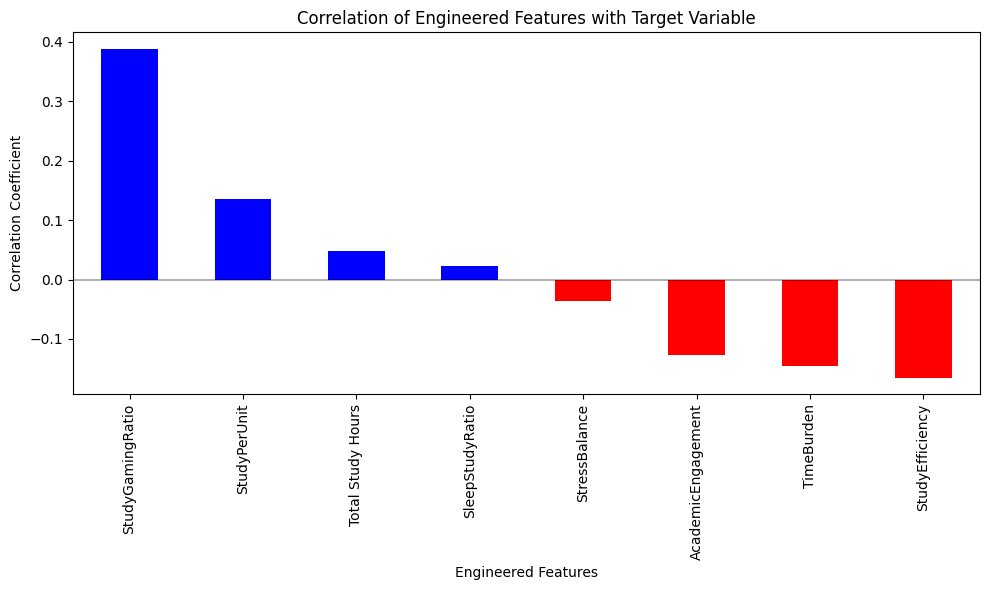

In [11]:
# Show correlation with target
if 'Target_Encoded' in correlation_matrix.columns:
      target_correlations = correlation_matrix['Target_Encoded'].sort_values(ascending=False)
      print("\nCorrelation with Target (At-Risk/Not At-Risk):")
      print(target_correlations)

        # Plot heatmap
      plt.figure(figsize=(10, 8))
      sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                    square=True, fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
      plt.title('Correlation Heatmap - Engineered Features', fontsize=16, pad=20)
      plt.tight_layout()
      plt.show()

        # Plot target correlations separately
      plt.figure(figsize=(10, 6))
      target_correlations_no_self = target_correlations.drop('Target_Encoded')
      colors = ['red' if x < 0 else 'blue' for x in target_correlations_no_self]
      target_correlations_no_self.plot(kind='bar', color=colors)
      plt.title('Correlation of Engineered Features with Target Variable')
      plt.xlabel('Engineered Features')
      plt.ylabel('Correlation Coefficient')
      plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
      plt.tight_layout()
      plt.show()

else:
  print("No engineered features were created or target column is missing")

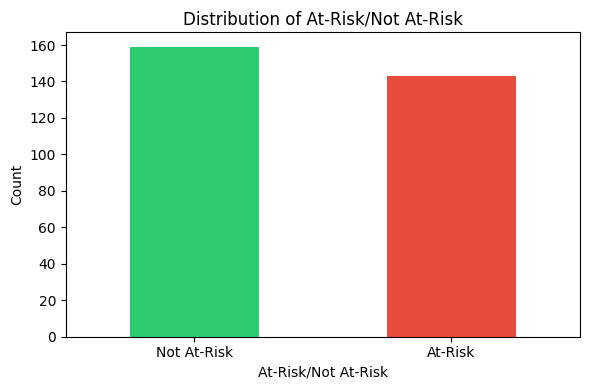

In [12]:
#target variable distribution
plt.figure(figsize=(6, 4))
df[target_col].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title(f'Distribution of {target_col}')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

###**PREPARE DATA FOR MODELING**

In [13]:
#separate features and target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print(f"\nOriginal class distribution:")
print(y.value_counts())
print(f"\nPercentage:")
print(y.value_counts(normalize=True) * 100)

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Original class distribution:
At-Risk/Not At-Risk
Not At-Risk    159
At-Risk        143
Name: count, dtype: int64

Percentage:
At-Risk/Not At-Risk
Not At-Risk    52.649007
At-Risk        47.350993
Name: proportion, dtype: float64

Features shape: (302, 27)
Target shape: (302,)


In [14]:
# If you want to use only engineered features, first create the engineered dataset
engineered_feature_names = ['Total Study Hours', 'StudyEfficiency', 'AcademicEngagement',
                          'StressBalance', 'TimeBurden', 'StudyGamingRatio',
                          'SleepStudyRatio', 'StudyPerUnit']

# Filter only the engineered features that exist in df_clean
existing_engineered_features = [feat for feat in engineered_feature_names if feat in df_clean.columns]

print(f"Using {len(existing_engineered_features)} engineered features:")
print(existing_engineered_features)

# Create X and y using only engineered features
X = df_clean[existing_engineered_features]
y = df_clean['At-Risk/Not At-Risk']

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nOriginal class distribution in y_train before SMOTE:")
print(pd.Series(y_train).value_counts())

# Check if all columns are numeric
print(f"\nData types in X_train:")
print(X_train.dtypes)

# Feature scaling (all engineered features should be numeric)
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Scaling complete for engineered features.")

# Apply SMOTE to the scaled training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("SMOTE applied. Class distribution after oversampling:")
print(pd.Series(y_train_res).value_counts())

# Update X_train and y_train to use the SMOTE-resampled and scaled data
X_train = X_train_res
y_train = y_train_res
X_test = X_test_scaled

print(f"\nFinal shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print("\nReady for model training with engineered features!")

Using 8 engineered features:
['Total Study Hours', 'StudyEfficiency', 'AcademicEngagement', 'StressBalance', 'TimeBurden', 'StudyGamingRatio', 'SleepStudyRatio', 'StudyPerUnit']
X shape: (302, 8), y shape: (302,)

Original class distribution in y_train before SMOTE:
At-Risk/Not At-Risk
Not At-Risk    127
At-Risk        114
Name: count, dtype: int64

Data types in X_train:
Total Study Hours     float64
StudyEfficiency       float64
AcademicEngagement      int64
StressBalance           int64
TimeBurden            float64
StudyGamingRatio      float64
SleepStudyRatio       float64
StudyPerUnit          float64
dtype: object
Scaling complete for engineered features.
SMOTE applied. Class distribution after oversampling:
At-Risk/Not At-Risk
Not At-Risk    127
At-Risk        127
Name: count, dtype: int64

Final shapes:
X_train: (254, 8), y_train: (254,)
X_test: (61, 8), y_test: (61,)

Ready for model training with engineered features!


###**MODEL EVALUATION**

In [15]:
target_classes = ['At-Risk', 'Not At-Risk']

# Logistic regression
lr = LogisticRegression(
    max_iter=500,
    class_weight="balanced"
)

lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]  # ADD THIS LINE

# Random forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Comprehensive model evaluation"""
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"{'='*60}")

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) == 2 else 0
    }

    for metric, value in metrics.items():
        print(f"{metric:.<20} {value:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_classes, zero_division=0))

    return metrics

lr_metrics = evaluate_model(y_test, lr_pred, y_pred_proba_lr, "LOGISTIC REGRESSION")
rf_metrics = evaluate_model(y_test, rf_pred, y_pred_proba_rf, "RANDOM FOREST")


LOGISTIC REGRESSION
Accuracy............ 0.6885
Precision........... 0.6919
Recall.............. 0.6885
F1-Score............ 0.6885
ROC-AUC............. 0.8103

Classification Report:
              precision    recall  f1-score   support

     At-Risk       0.66      0.72      0.69        29
 Not At-Risk       0.72      0.66      0.69        32

    accuracy                           0.69        61
   macro avg       0.69      0.69      0.69        61
weighted avg       0.69      0.69      0.69        61


RANDOM FOREST
Accuracy............ 1.0000
Precision........... 1.0000
Recall.............. 1.0000
F1-Score............ 1.0000
ROC-AUC............. 1.0000

Classification Report:
              precision    recall  f1-score   support

     At-Risk       1.00      1.00      1.00        29
 Not At-Risk       1.00      1.00      1.00        32

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00    

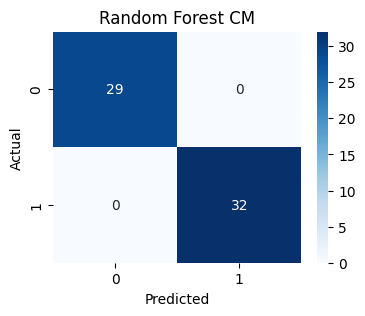

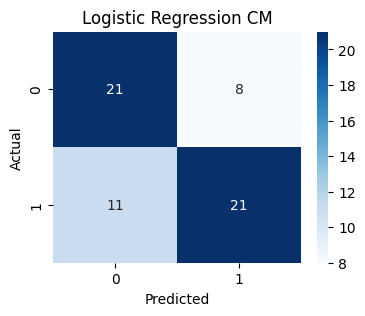

In [16]:
#confusion matrix

def show_cm(title, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

show_cm("Random Forest CM", y_test, rf_pred)
show_cm("Logistic Regression CM", y_test, lr_pred)

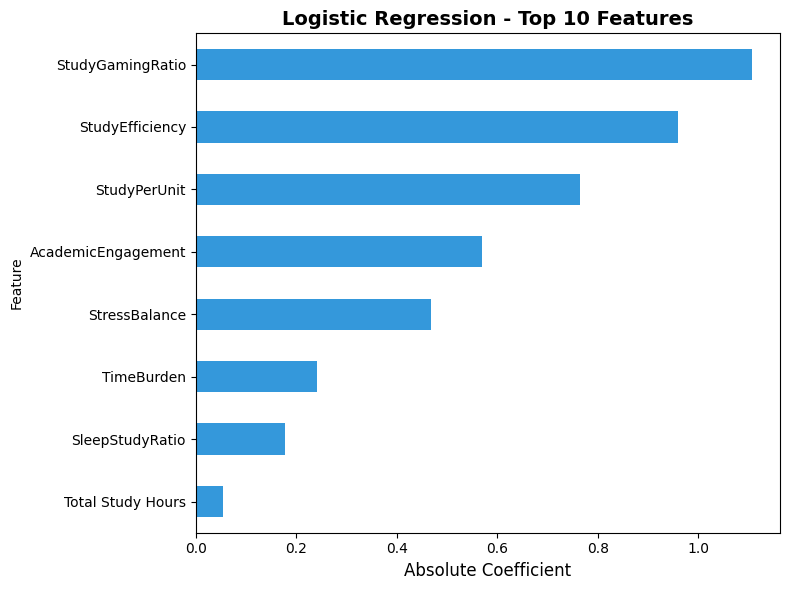

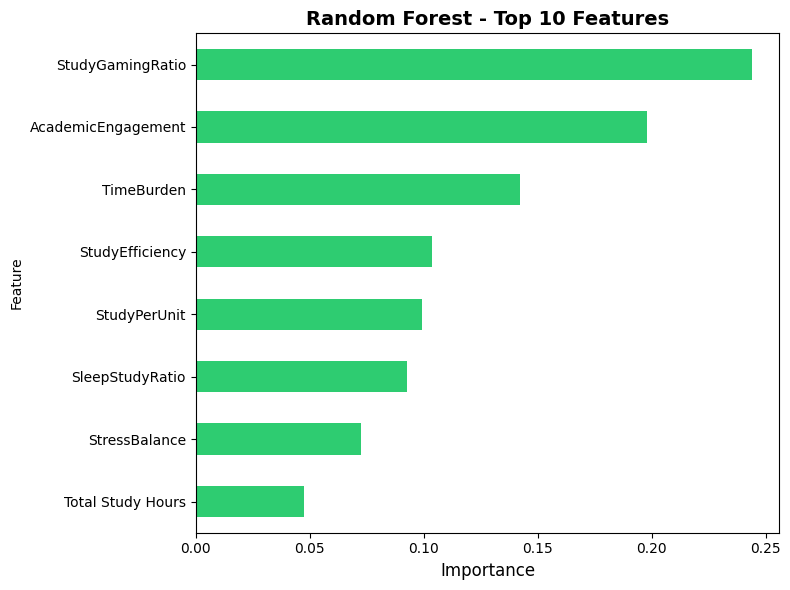

In [17]:
#logistic regression coefficients
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

feature_importance_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(lr.coef_[0])
}).sort_values('Coefficient', ascending=False).head(10)

feature_importance_lr.plot(x='Feature', y='Coefficient', kind='barh',
                          ax=axes, color='#3498db', legend=False)
axes.set_title('Logistic Regression - Top 10 Features', fontsize=14, fontweight='bold')
axes.set_xlabel('Absolute Coefficient', fontsize=12)
axes.invert_yaxis()
plt.tight_layout()
plt.show()

#random forest feature importance
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

feature_importance_rf.plot(x='Feature', y='Importance', kind='barh',
                          ax=axes, color='#2ecc71', legend=False)
axes.set_title('Random Forest - Top 10 Features', fontsize=14, fontweight='bold')
axes.set_xlabel('Importance', fontsize=12)
axes.invert_yaxis()
plt.tight_layout()
plt.show()

In [18]:
print("\n=== STUDENT RISK PREDICTION ===")

# Use only Logistic Regression
best_model_obj = lr
print("Using Logistic Regression model")

# Get the actual column names from your training data
if 'X' in locals():
    base_features_for_input = X.columns.tolist()
else:
    # Fallback to expected engineered features
    base_features_for_input = [
        'Total Study Hours', 'StudyEfficiency', 'AcademicEngagement',
        'StressBalance', 'TimeBurden', 'StudyGamingRatio',
        'SleepStudyRatio', 'StudyPerUnit'
    ]

print(f"\nEnter the student's information:")

user_data_raw = {}

# First ask about extracurricular involvement
print("\n--- OUTSIDE ACTIVITIES ---")
while True:
    extracurricular_involved = input("Are you involved in extracurricular activities? (yes/no): ").strip().lower()
    if extracurricular_involved in ['yes', 'y', 'no', 'n']:
        break
    print("Please enter 'yes' or 'no'")

# Only ask for extracurricular hours if involved
extracurricular_hours = 0
if extracurricular_involved in ['yes', 'y']:
    while True:
        try:
            extracurricular_hours = float(input("Hours spent on extracurricular activities per week: ").strip())
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

while True:
    gaming_hours = input("Are you playing games? (yes/no): ").strip().lower()
    if gaming_hours in ['yes', 'y', 'no', 'n']:
        break
    print("Please enter 'yes' or 'no'")

if gaming_hours in ['yes', 'y']:
  while True:
    try:
        gaming_hours = float(input("Hours spent playing games per day: ").strip())
        break
    except ValueError:
      print("Invalid input. Please enter a numeric value.")


# Ask about part-time work
print("\n--- PART-TIME WORK ---")
while True:
    part_time_work = input("Do you work part-time? (yes/no): ").strip().lower()
    if part_time_work in ['yes', 'y', 'no', 'n']:
        break
    print("Please enter 'yes' or 'no'")

# Only ask for work hours if working part-time
work_hours = 0
if part_time_work in ['yes', 'y']:
    while True:
        try:
            work_hours = float(input("Work Hours per week: ").strip())
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")


# Study-related information
print("\n--- STUDY INFORMATION ---")
study_weekdays = float(input("Study Hours (Weekdays): ").strip())
study_weekends = float(input("Study Hours (Weekends): ").strip())
user_data_raw['Study Hours (Weekdays)'] = study_weekdays
user_data_raw['Study Hours (Weekends)'] = study_weekends

# Calculate Total Study Hours first
user_data_raw['Total Study Hours'] = study_weekdays + study_weekends

# Late submissions
late_submissions = float(input("Late Submissions frequency (1=Never, 2=Rarely, 3=Sometimes, 4=Often): ").strip())
user_data_raw['Late Submissions'] = late_submissions

# Academic units
academic_units = float(input("Number of Academic Units: ").strip())

# Well-being information
print("\n--- WELL-BEING ---")
stress_level = float(input("Stress Level (1-5 scale): ").strip())
social_support = float(input("Level of Social Support (1-5 scale): ").strip())
sleep_hours = float(input("Sleep Hours per night: ").strip())
financial_difficulty = float(input("Level of Social Support (1-5 scale): ").strip())

# Now calculate all engineered features
print("\nCalculating engineered features...")

# Study Efficiency
user_data_raw['StudyEfficiency'] = user_data_raw['Total Study Hours'] / (late_submissions + 0.1)

# Academic Engagement (use extracurricular_hours which is 0 if not involved)
user_data_raw['AcademicEngagement'] = extracurricular_hours + social_support

# Stress Balance
user_data_raw['StressBalance'] = stress_level - social_support

# Time Burden (use work_hours which is 0 if not working)
user_data_raw['TimeBurden'] = work_hours + gaming_hours

# Study Gaming Ratio
gaming_hours_adj = gaming_hours if gaming_hours > 0 else 0.1
user_data_raw['StudyGamingRatio'] = user_data_raw['Total Study Hours'] / gaming_hours_adj

# Sleep Study Ratio
user_data_raw['SleepStudyRatio'] = sleep_hours / (user_data_raw['Total Study Hours'] + 1)

# Study Per Unit
academic_units_adj = academic_units if academic_units > 0 else 0.1
user_data_raw['StudyPerUnit'] = user_data_raw['Total Study Hours'] / (academic_units_adj + 0.1)

# Convert to DataFrame with only the engineered features
user_df = pd.DataFrame([user_data_raw])

# Keep only the columns that are in our training features
if 'X' in locals():
    available_features = [col for col in base_features_for_input if col in user_df.columns]
    user_final_features = user_df[available_features]

    # Fill any missing columns with 0
    for col in X.columns:
        if col not in user_final_features.columns:
            user_final_features[col] = 0

    # Reorder columns to match training data
    user_final_features = user_final_features[X.columns]
else:
    user_final_features = user_df[base_features_for_input]

print(f"\nInput features shape: {user_final_features.shape}")

# Scale the features
try:
    user_scaled = scaler.transform(user_final_features)
    print("Features scaled successfully")
except Exception as e:
    print(f"Scaling error: {e}")
    # If scaling fails, use original features
    user_scaled = user_final_features.values

# Prediction using Logistic Regression
try:
    pred = best_model_obj.predict(user_scaled)[0]
    proba = best_model_obj.predict_proba(user_scaled)[0]

    # Determine which probability corresponds to which class
    classes = best_model_obj.classes_
    if 'At-Risk' in classes:
        at_risk_idx = list(classes).index('At-Risk')
        not_at_risk_idx = list(classes).index('Not At-Risk')
        prob_at_risk = proba[at_risk_idx]
        prob_not_risk = proba[not_at_risk_idx]
    else:
        # If classes are encoded as 0/1
        prob_at_risk = proba[1] if pred == 1 else proba[0]
        prob_not_risk = proba[0] if pred == 1 else proba[1]

    # === OUTPUT ===
    print("\n" + "="*50)
    print("PREDICTION RESULT")
    print("="*50)

    if pred == 'At-Risk' or pred == 1:
        print("Prediction: AT-RISK")
        print(f"Confidence: {prob_at_risk:.1%}")
    else:
        print("Prediction: NOT AT-RISK")
        print(f"Confidence: {prob_not_risk:.1%}")

    print(f"\nDetailed probabilities:")
    print(f"Probability of At-Risk: {prob_at_risk:.1%}")
    print(f"Probability of Not At-Risk: {prob_not_risk:.1%}")

    # Show key feature values
    print(f"\nKey calculated features:")
    print(f"• Total Study Hours: {user_data_raw['Total Study Hours']:.1f}")
    print(f"• Study Efficiency: {user_data_raw['StudyEfficiency']:.1f}")
    print(f"• Academic Engagement: {user_data_raw['AcademicEngagement']:.1f}")
    print(f"• Stress Balance: {user_data_raw['StressBalance']:.1f}")
    print(f"• Time Burden: {user_data_raw['TimeBurden']:.1f}")
    print(f"• Study-Gaming Ratio: {user_data_raw['StudyGamingRatio']:.1f}")
    print(f"• Financial Difficulty: {financial_difficulty}")
    print(f"• Part-time Work: {'Yes' if part_time_work in ['yes', 'y'] else 'No'}")
    if part_time_work in ['yes', 'y']:
        print(f"• Work Hours per week: {work_hours}")

except Exception as e:
    print(f"Prediction error: {e}")


=== STUDENT RISK PREDICTION ===
Using Logistic Regression model

Enter the student's information:

--- OUTSIDE ACTIVITIES ---
Are you involved in extracurricular activities? (yes/no): YES
Hours spent on extracurricular activities per week: 8
Are you playing games? (yes/no): YES
Hours spent playing games per day: 5

--- PART-TIME WORK ---
Do you work part-time? (yes/no): YES
Work Hours per week: 8

--- STUDY INFORMATION ---
Study Hours (Weekdays): 5
Study Hours (Weekends): 5
Late Submissions frequency (1=Never, 2=Rarely, 3=Sometimes, 4=Often): 1
Number of Academic Units: 18

--- WELL-BEING ---
Stress Level (1-5 scale): 1
Level of Social Support (1-5 scale): 1
Sleep Hours per night: 1
Level of Social Support (1-5 scale): 1

Calculating engineered features...

Input features shape: (1, 8)
Features scaled successfully

PREDICTION RESULT
Prediction: NOT AT-RISK
Confidence: 90.7%

Detailed probabilities:
Probability of At-Risk: 9.3%
Probability of Not At-Risk: 90.7%

Key calculated features

In [19]:
54

54